#%%[markdown]

 # Neural ODE mixed with SINDy framework with mixture of experts
## Summary
 - We have a multistable dynamical systems that we want to learn
 - We only learn on a single attrator
 - Does it learn the other attractor ?
## Aproach
 - We have a neural networks
 - We initialise two of them seperately
 - We apply our Taylor based self-regularisation to it

In [ ]:
#%%

import jax

print("Available devices:", jax.devices())

from jax import config
# config.update("jax_debug_nans", True)

import jax.numpy as jnp

import numpy as np
from scipy.integrate import solve_ivp

import equinox as eqx
import diffrax

# import matplotlib.pyplot as plt

from sinode import *

import optax
import time

Available devices: [CudaDevice(id=0)]


In [ ]:
#%%

SEED = 2025
np.random.seed(SEED)
main_key = jax.random.PRNGKey(SEED)

mlp_hidden_size = 32
mlp_depth = 3

## Optimiser hps
init_lr = 5e-3

## Training hps
print_every = 500
nb_epochs = 5000

## Data generation hps
T_horizon = 20
skip = 50

Data shape: (1, 62, 40, 2)


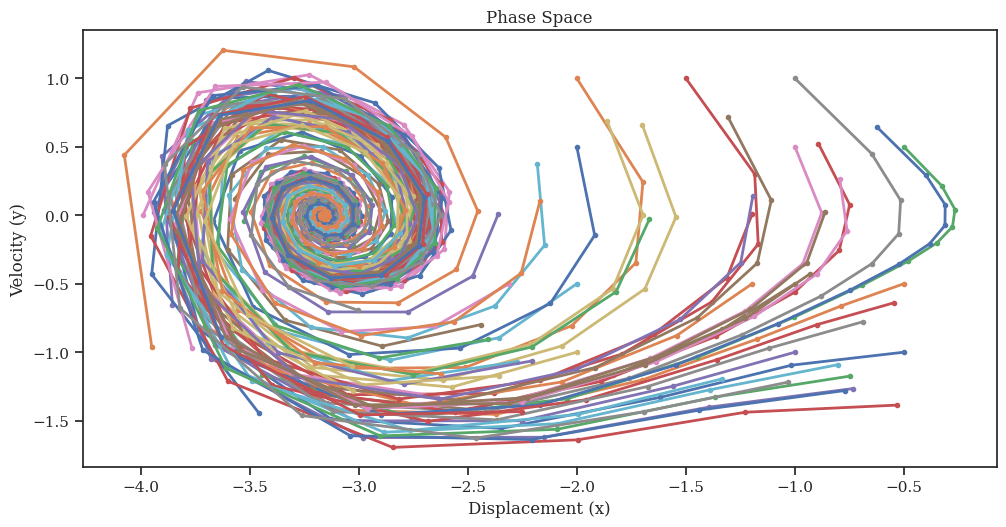

In [ ]:
#%%

# Define the Duffing system
def duffing(t, state, a, b, c):
    x, y = state
    dxdt = y
    dydt = a*y - x*(b + c*x**2)
    return [dxdt, dydt]


# Parameters
a, b, c = -1/2., -1, 1/10.

t_span = (0, T_horizon)
t_eval = np.arange(t_span[0], t_span[1], 0.01)[::skip]

init_conds = np.array([[-0.5, -1], [-0.5, -0.5], [-0.5, 0.5], 
                       [-1.5, 1], 
                    #    [-0.5, 1], 
                       [-1, -1], [-1, -0.5], [-1, 0.5], [-1, 1], 
                       [-2, -1], [-2, -0.5], [-2, 0.5], [-2, 1],
                    #    [0.5, -1], [0.5, -0.5], [0.5, 0.5], [0.5, 1],
                    #    [1, -1], [1, -0.5], [1, 0.5], [1, 1],
                    #    [2, -1], [2, -0.5], [2, 0.5], [2, 1],
                       ])


add_init_conds_x = np.random.uniform(-4, -0.5, 50)
add_init_conds_y = np.random.uniform(-1.5, 0.75, 50)
add_init_conds = np.stack([add_init_conds_x, add_init_conds_y], axis=-1)

init_conds = np.concatenate([init_conds, add_init_conds], axis=0)

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
train_data = []

for state0 in init_conds:
    sol = solve_ivp(duffing, t_span, state0, args=(a, b, c), t_eval=t_eval)
    train_data.append(sol.y.T)

    ## Plot the phase space
    ax = sbplot(sol.y[0], sol.y[1], ".-", ax=ax, dark_background=True)

ax.set_xlabel('Displacement (x)')
ax.set_ylabel('Velocity (y)')
ax.set_title('Phase Space')


## Save the training data
data = np.stack(train_data)[None, ...]

print("Data shape:", data.shape)

In [ ]:
# %%

class VectorField(eqx.Module):
    mlp: eqx.Module

    def __init__(self, data_size, mlp_hidden_size, mlp_depth, key=None):

        self.mlp = eqx.nn.MLP(data_size, 
                              data_size, 
                              mlp_hidden_size, 
                              mlp_depth, 
                              use_bias=True, 
                              activation=jax.nn.softplus,
                              key=key)


    def __call__(self, t, x, args):
        """ Forward call of the vector field """
        return self.mlp(x)

class NeuralODE(eqx.Module):
    data_size: int
    mlp_hidden_size: int
    mlp_depth: int

    vector_field: VectorField

    def __init__(self, data_size, mlp_hidden_size, mlp_depth, key=None):
        self.data_size = data_size
        self.mlp_hidden_size = mlp_hidden_size
        self.mlp_depth = mlp_depth

        self.vector_field = VectorField(data_size, mlp_hidden_size, mlp_depth, key=key)

    def __call__(self, x0s, t_eval):

        def integrate(y0):
            sol = diffrax.diffeqsolve(
                    diffrax.ODETerm(self.vector_field),
                    diffrax.Tsit5(),
                    # args=(),
                    t0=t_eval[0],
                    t1=t_eval[-1],
                    dt0=1e-3,
                    y0=y0,
                    stepsize_controller=diffrax.PIDController(rtol=1e-3, atol=1e-6),
                    saveat=diffrax.SaveAt(ts=t_eval),
                    # adjoint=diffrax.RecursiveCheckpointAdjoint(),
                    max_steps=4096
                )
            return sol.ys

            # sol = RK4(self.vector_field, 
            #           (t_eval[0], t_eval[-1]), 
            #           y0, 
            #           (coeffs.lambdas, coeffs.gammas), 
            #           t_eval=t_eval, 
            #           subdivisions=4)
            # return sol

        return eqx.filter_vmap(integrate)(x0s)

In [ ]:
# %%

model_keys = jax.random.split(main_key, num=2)

model = NeuralODE(data_size=2, mlp_hidden_size=mlp_hidden_size, mlp_depth=mlp_depth, key=model_keys[0])

In [ ]:
# %%

def loss_rec(model, batch):
    """ Reconstruction loss """
    X, t = batch
    X_hat = model(X[:, 0, :], t)
    return jnp.mean((X-X_hat)**2)


def loss_fn(model, batch):

    rec_loss = loss_rec(model, batch)

    ## Regularisation loss ?

    return rec_loss



@eqx.filter_jit
def train_step(model, batch, opt_state):
    print('\nCompiling function "train_step" for Node ...\n')

    loss, grads = eqx.filter_value_and_grad(loss_fn)(model, batch)

    updates, opt_state = opt_node.update(grads, opt_state)
    model = eqx.apply_updates(model, updates)

    return model, opt_state, loss

In [ ]:
#%%

total_steps = nb_epochs     ## 1 step per epoch with full batch

# sched = optax.linear_schedule(init_lr, 0, total_steps, 0.25)
# sched_factor = 1.0
# boundaries_and_scales={int(total_steps*0.25):sched_factor, int(total_steps*0.5):sched_factor, int(total_steps*0.75):sched_factor}
# sched_node = optax.piecewise_constant_schedule(init_value=init_lr, boundaries_and_scales=boundaries_and_scales)

sched_node = optax.exponential_decay(init_value=init_lr, transition_steps=100, decay_rate=0.99)

nb_data_points = data.shape[1]
batch_size = nb_data_points

opt_node = optax.adam(sched_node)
opt_state_node = opt_node.init(eqx.filter(model, eqx.is_array))



start_time = time.time()

print(f"\n\n=== Beginning Training ... ===")

train_key, _ = jax.random.split(main_key)

losses_node = []

for epoch in range(nb_epochs):

    nb_batches = 0
    loss_sum_node = 0.

    for i in range(0, nb_data_points, batch_size):
        batch = (data[0,i:i+batch_size,...], t_eval)
    
        model, opt_state_node, loss = train_step(model, batch, opt_state_node)

        loss_sum_node += loss

        nb_batches += 1

    loss_epoch_node = loss_sum_node/nb_batches
    losses_node.append(loss_epoch_node)

    if epoch%print_every==0 or epoch<=3 or epoch==nb_epochs-1:
        print(f"    Epoch: {epoch:-5d}      LossNode: {loss_epoch_node:.8f}", flush=True)

wall_time = time.time() - start_time
time_in_hmsecs = seconds_to_hours(wall_time)
print("\nTotal GD training time: %d hours %d mins %d secs" %time_in_hmsecs)



=== Beginning Training ... ===

Compiling function "train_step" for Node ...

    Epoch:     0      LossNode: 35.68616867
    Epoch:     1      LossNode: 9.67634964
    Epoch:     2      LossNode: 1.52136075
    Epoch:     3      LossNode: 2.58438492
    Epoch:   500      LossNode: 0.10540288
    Epoch:  1000      LossNode: 0.02968922
    Epoch:  1500      LossNode: 0.00352108
    Epoch:  2000      LossNode: 0.00142754
    Epoch:  2500      LossNode: 0.00083329
    Epoch:  3000      LossNode: 0.00049531
    Epoch:  3500      LossNode: 0.00055758
    Epoch:  4000      LossNode: 0.00032019
    Epoch:  4500      LossNode: 0.00018510
    Epoch:  4999      LossNode: 0.00017035

Total GD training time: 0 hours 53 mins 51 secs


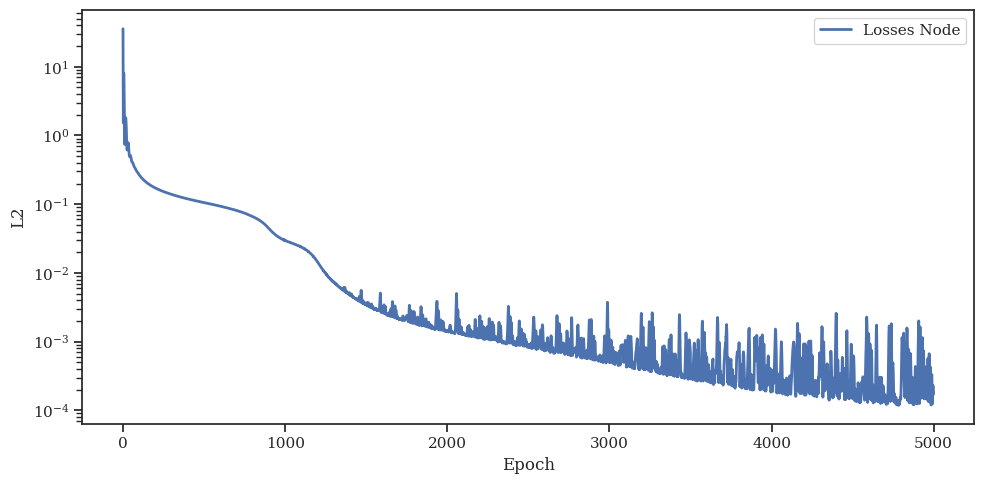

In [ ]:
# %%

## Shift the losses so that they start from 0

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax = sbplot(np.array(losses_node), x_label='Epoch', y_label='L2', y_scale="log", label='Losses Node', ax=ax, dark_background=True);

plt.legend()

plt.draw();

plt.savefig(f"data/loss.png", dpi=300, bbox_inches='tight')

In [ ]:
#%% 

eqx.tree_serialise_leaves("data/sinode_model_07.eqx", model)

Test MSE: 1.40433228


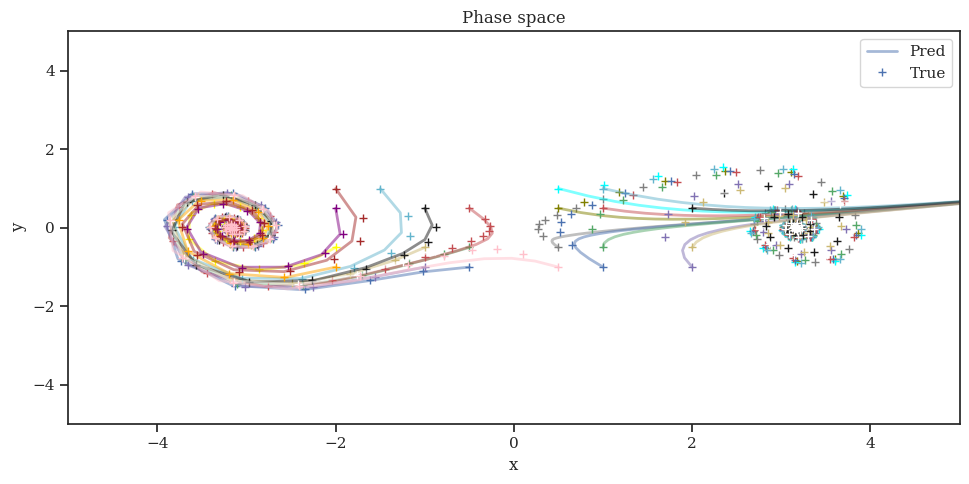

In [ ]:
# %%

model = eqx.tree_deserialise_leaves("data/sinode_model_07.eqx", model)

## %%

## Test the model
def test_model(model, batch):
    X0, t = batch
    X_hat = model(X0[:, :], t)
    return X_hat

init_conds_test = np.array([[-0.5, -1], [-0.5, -0.5], [-0.5, 0.5], 
                       [-1.5, 1], 
                    #    [-0.5, 1], 
                       [-1, -1], [-1, -0.5], [-1, 0.5], [-1, 1], 
                       [-2, -1], [-2, -0.5], [-2, 0.5], [-2, 1],
                       [0.5, -1], [0.5, -0.5], [0.5, 0.5], [0.5, 1],
                       [1, -1], [1, -0.5], [1, 0.5], [1, 1],
                       [2, -1], [2, -0.5], [2, 0.5], [2, 1],
                       ])
test_data = []
for state0 in init_conds_test:
    sol = solve_ivp(duffing, t_span, state0, args=(a, b, c), t_eval=t_eval)
    test_data.append(sol.y.T)
test_data = np.stack(test_data)[None, ...]


X = test_data[0, :, :, :]
# t = np.linspace(t_span[0], t_span[1], T_horizon)
t = t_eval

X_hat = test_model(model, (X[:, 0,:], t))

print(f"Test MSE: {jnp.mean((X-X_hat)**2):.8f}")

fig, ax = plt.subplots(1, 1, figsize=(10, 5))

colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w', 'orange', 'yellow', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']
colors = colors*10

for i in range(X.shape[0]):
    if i==0:
        sbplot(X_hat[i, :,0], X_hat[i, :,1], "-", x_label='x', y_label='y', label=f'Pred', title=f'Phase space', ax=ax, alpha=0.5, color=colors[i])
        sbplot(X[i, :,0], X[i, :,1], "+", lw=1, label=f'True', ax=ax, color=colors[i])
    else:
        sbplot(X_hat[i, :,0], X_hat[i, :,1], "-", x_label='x', y_label='y', ax=ax, alpha=0.5, color=colors[i])
        sbplot(X[i, :,0], X[i, :,1], "+", lw=1, ax=ax, color=colors[i])

## Limit ax x and y axis to (-5,5)
ax.set_xlim(-5, 5)
ax.set_ylim(-5, 5)
plt.draw();



plt.savefig(f"data/test_traj_7.png", dpi=300, bbox_inches='tight')

# %% [markdown]

 # Preliminary results
 - Nothing yet !